In [3]:
#Imports
#Dataprep
import matplotlib.pyplot as plt #plots
import numpy as np 
from nilearn import datasets, plotting, image #plotting and example datasets
from nilearn.maskers import NiftiMapsMasker #testing with real data
from sklearn.decomposition import FastICA  #testing with real data
import pandas as pd #data preposcessing 
import tarfile #filehelper
import gzip #file helper
#GNN required
import torch
import torch.nn.functional as F
from torch.nn import Linear 
import torch.nn as nn
import torch_geometric 
from torch_geometric.nn import GCNConv #GCN method used for our model
from torch_geometric.nn import SAGEConv #usused type GCN
from torch_geometric.nn import GraphConv #GCN alternative
from torch_geometric.data import Data #Data tuple
from torch_geometric.loader import DataLoader
from torch.utils.data import SubsetRandomSampler #suffling
from sklearn.metrics import accuracy_score #calculate accuracy
import pingouin as pg # for data sim
import time #timing

### GNN setup

In [4]:
def collate(data_list):
    graphs, labels = map(list, zip(*data_list))
    return {
        'graph': graphs,
        'label': labels
    }

In [21]:
def edge_gen_treshold(netmat, treshold):
    mask = np.triu(abs(netmat) > treshold, k=0) # using only bottom triangle 
    edge_i = np.transpose(np.nonzero(mask))
    return torch.tensor(edge_i.T)

In [6]:
import random

In [58]:
class CorrelationDataset(torch.utils.data.Dataset):
    def __init__(self, netmats, labels, edges, split_ratio=(0.8, 0.1, 0.1)):
        self.netmats = netmats
        self.labels = labels
        self.edges = edges 
        self.split_ratios = split_ratio
        tot = len(self.netmats)
        train_samples = int(split_ratio[0] * tot)
        val_samples = int(split_ratio[1] * tot)
        
        #suffle
        indices = list(range(tot))
        random.shuffle(indices)
        
        # splits
        self.train_indices = indices[:train_samples]  # 0 - train_samples
        self.val_indices = indices[train_samples:train_samples + val_samples]
        self.test_indices = indices[train_samples + val_samples:]
        
    def __len__(self):
        return len(self.netmats)

    def __getitem__(self, idx):
        nmap = torch.tensor(self.netmats.iloc[idx]).float()
        edge_index = edge_gen_treshold(nmap, 0.3) # Change treshold here (two is great from testing)
        graph_data = Data(x=nmap, edge_index=edge_index)
        label = self.labels[idx]
        return graph_data, label
    
    def get_split(self, idx):
        if idx in self.train_indices:
            return 'train'
        elif idx in self.val_indices:
            return 'val'
        elif idx in self.test_indices:
            return 'test'
        else:
            raise ValueError('Index not in any split')

In [81]:
class GCN(nn.Module):
    def __init__(self, hidden_d):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(100, hidden_d)
        self.bn1 = nn.BatchNorm1d(hidden_d)
        self.conv2 = GCNConv(hidden_d, hidden_d)
        #self.bn2 = nn.BatchNorm1d(hidden_d)
        self.classifier = Linear(hidden_d, 1)

    def forward(self, data):
        data = data['graph'][0]
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.75)(x)
        x = self.conv2(x, edge_index)
        #x = self.bn2(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.75)(x)
        x = self.classifier(x).mean(dim=0)
        return x

In [42]:
def train(model, data_loader, device, loss_fn, optimizer):
    model.train()
    total_loss = 0
    num_true = 0
    num_true_guesses = 0
    for d in data_loader:
        m = d['graph'][0]
        m = m.to(device)
        label = d['label'][0]
        optimizer.zero_grad()
        out = model(d).squeeze()
        loss = loss_fn(out.float(), label.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = (out.double() > 0.5).float()
        if pred == label.float():
            num_true += 1
        if pred == 1:
            num_true_guesses += 1
    return total_loss, num_true, num_true_guesses

def eval(model, loader, device, loss_fn):
    model.eval()
    cor = 0
    tot = 0
    total_loss = 0
    for d in loader:
        with torch.no_grad():
            out = model(d)
            pred = (out.float() > 0.5).float()
        y = d['label'][0]
        cor += (pred == y).sum()
        tot += 1
        total_loss += loss_fn(out.squeeze().float(), y.float())
    return cor/tot, total_loss

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def conf_m(model, loader, device):
    model.eval()
    predictions = []
    labels = []
    for d in loader:
        with torch.no_grad():
            out = model(d)
            pred = (out.float() > 0.5).float()
            predictions.append(pred.numpy())
            labels.append(d['label'][0].numpy())
    predictions = predictions
    labels = labels
    cm = confusion_matrix(labels, predictions)
    cm_norm = cm/len(loader)
    c_names = ['True Neg','False Pos','False Neg','True Pos']
    c_counts = cm.flatten()
    c_percentages = ["{0:.2%}".format(value) for value in cm_norm.flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(c_names,c_counts,c_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    s = sn.heatmap(cm_norm, annot=labels, fmt='', cmap='Blues')
    s.set(xlabel="Predicted", ylabel="True")
    plt.show()

### From sim_correlation_gen

In [10]:
def gen_subject(func,func_args,num_f,b):
    w = func(np.arange(0,10,0.1),**func_args,b=b)
    df = gen_data_revised(w,100,num_features = num_f)
    return df

In [11]:
def gen_dist(func,func_args,num_f,num_each,b1,b2):
    df = pd.DataFrame(columns = ['gender', 'data', 'corr', 'pcorr', 'fcorr', 'fpcorr'])

    # gen m
    for i in np.arange(num_each):
        subject = gen_subject(func,func_args,num_f,b1)
        corr = subject.corr()
        pcorr = subject.pcorr()
        fcorr = apply_fisher(corr)
        fpcorr = apply_fisher(pcorr)

        df.loc[len(df.index)] = ['M',subject.to_numpy(),corr.to_numpy(),pcorr.to_numpy(),fcorr,fpcorr]

    # gen f
    for i in np.arange(num_each):
        subject = gen_subject(func,func_args,num_f,b2)
        corr = subject.corr()
        pcorr = subject.pcorr()
        fcorr = apply_fisher(corr)
        fpcorr = apply_fisher(pcorr)

        df.loc[len(df.index)] = ['F',subject.to_numpy(),corr.to_numpy(),pcorr.to_numpy(),fcorr,fpcorr]
    
    return df

In [12]:
def f3(x,b,f1,s1,f2,s2,f3,s3,amp,width):
    return amp*(f1*np.sin(s1*x)+f2*np.sin(s2*np.e*x)+f3*np.sin(s3*np.pi*x)) * \
           ((2*np.pi)**(-1/2)) * np.e**(-0.5*((x-b)/width)**2) + 1

In [13]:
arg100e = {'f1':1.9,'s1':3,'f2':6,'s2':5,'f3':4.5,'s3':1.3,'amp':0.1,'width':7}

In [14]:
num_f = 100
num_each = 500
b1 = 0
b2 = 0
func = f3
func_args = arg100e

In [15]:
def apply_fisher(data):
    numpied = data.to_numpy().copy()
    np.fill_diagonal(numpied, 0)
    return np.arctanh(numpied)

In [16]:
def gen_data_revised(active_weights,num_rows,num_features = 10,active_proportion = 0.4):
    # generate dataframe of gaussian noise
    df = pd.DataFrame(np.random.normal(1,0.1,size=(num_rows, num_features)))
    
    # split into active and inactive sets
    split_index = int(df[0].size * active_proportion)
    active, inactive = df.iloc[:split_index],df.iloc[split_index:]
    
    # multiply active set by diagonal matrix of weights
    active_mult = np.matmul(active,np.diag(active_weights))
    
    # join the two sets
    return pd.concat([active_mult,inactive])

In [15]:
dist0 = gen_dist(func,func_args,num_f,num_each,0,0)
dist2 = gen_dist(func,func_args,num_f,num_each,0,2)
dist4 = gen_dist(func,func_args,num_f,num_each,0,4)
dist6 = gen_dist(func,func_args,num_f,num_each,0,6)
dist8 = gen_dist(func,func_args,num_f,num_each,0,8)
dist10 = gen_dist(func,func_args,num_f,num_each,0,10)

In [16]:
dist0 = dist0[['gender', 'fpcorr']]
dist2 = dist2[['gender', 'fpcorr']]
dist4 = dist4[['gender', 'fpcorr']]
dist6 = dist6[['gender', 'fpcorr']]
dist8 = dist8[['gender', 'fpcorr']]
dist10 = dist10[['gender', 'fpcorr']]

In [17]:
torch.tensor(dist0.iloc[0].fpcorr).size()

torch.Size([100, 100])

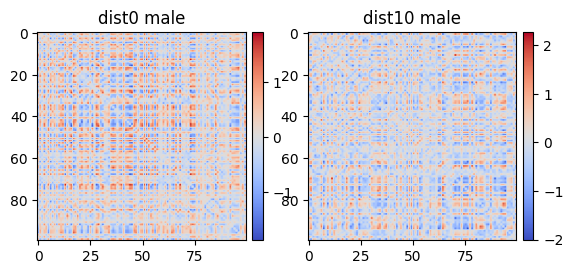

In [18]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8,8))
c = ax0.imshow(torch.tensor(dist0.iloc[5].fpcorr), cmap='coolwarm')
fig.colorbar(c, ax=ax0, fraction=0.046, pad=0.03)
ax0.set_title('dist0 male')
c = ax1.imshow(torch.tensor(dist10.iloc[5].fpcorr), cmap='coolwarm')
ax1.set_title('dist10 male')
fig.colorbar(c, ax=ax1, fraction=0.046, pad=0.03)
plt.show()

In [2]:
def gen_dist2(func,func_args,num_f,num_each,b1,b2):
    df = pd.DataFrame(columns = ['gender','corr'])

    # gen m
    for i in np.arange(num_each):
        subject = gen_subject(func,func_args,num_f,b1)
        corr = subject.corr()
#         fcorr = apply_fisher(corr)

        df.loc[len(df.index)] = ['M',corr.to_numpy().astype('float16')]

    # gen f
    for i in np.arange(num_each):
        subject = gen_subject(func,func_args,num_f,b2)
        corr = subject.corr()
#         fcorr = apply_fisher(corr)

        df.loc[len(df.index)] = ['F',corr.to_numpy().astype('float16')]
    
    return df

### Lower separability

In [17]:
dist00 = gen_dist2(func,func_args,num_f,num_each,0,0)
dist01 = gen_dist2(func,func_args,num_f,num_each,0,0.1)
dist02 = gen_dist2(func,func_args,num_f,num_each,0,0.2)
dist03 = gen_dist2(func,func_args,num_f,num_each,0,0.3)
dist04 = gen_dist2(func,func_args,num_f,num_each,0,0.4)
dist05 = gen_dist2(func,func_args,num_f,num_each,0,0.5)

In [18]:
dist06 = gen_dist2(func,func_args,num_f,num_each,0,0.6)
dist07 = gen_dist2(func,func_args,num_f,num_each,0,0.7)
dist08 = gen_dist2(func,func_args,num_f,num_each,0,0.8)
dist09 = gen_dist2(func,func_args,num_f,num_each,0,0.9)
dist10 = gen_dist2(func,func_args,num_f,num_each,0,1.0)

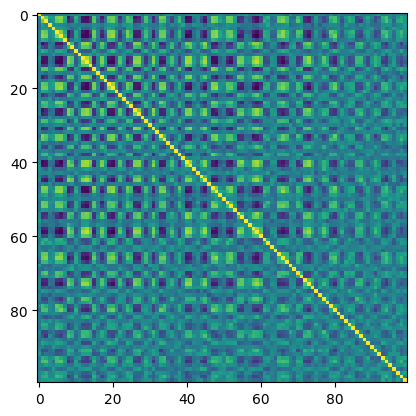

In [33]:
plt.imshow(torch.tensor(dist00.iloc[0]['corr']))

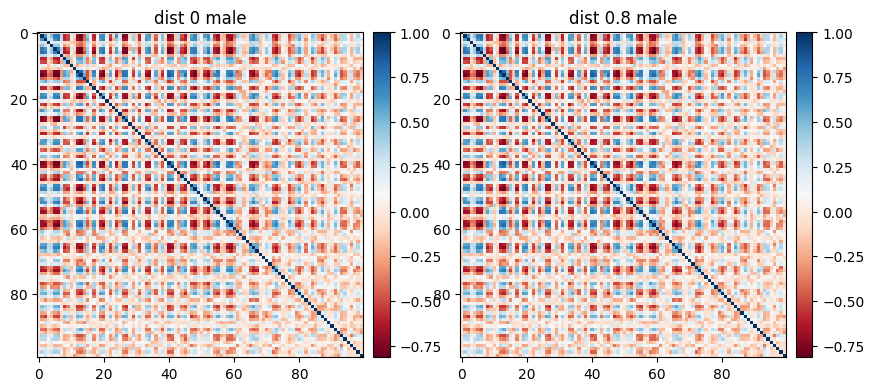

In [35]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,10))
c = ax0.imshow(torch.tensor(dist00.iloc[5]['corr']), cmap='RdBu')
fig.colorbar(c, ax=ax0, fraction=0.046, pad=0.03)
ax0.set_title('dist 0 male')
c = ax1.imshow(torch.tensor(dist00.iloc[5]['corr']), cmap='RdBu')
ax1.set_title('dist 0.8 male')
fig.colorbar(c, ax=ax1, fraction=0.046, pad=0.03)
plt.show()

In [38]:
dist00.iloc[505].gender

'F'

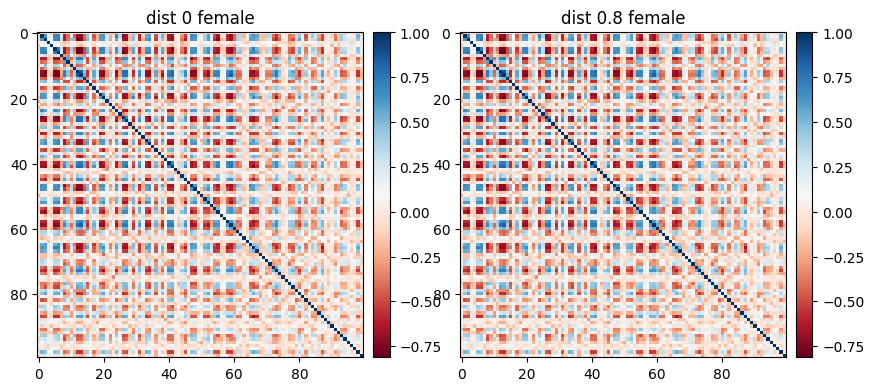

In [36]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,10))
c = ax0.imshow(torch.tensor(dist00.iloc[505]['corr']), cmap='RdBu')
fig.colorbar(c, ax=ax0, fraction=0.046, pad=0.03)
ax0.set_title('dist 0 female')
c = ax1.imshow(torch.tensor(dist00.iloc[505]['corr']), cmap='RdBu')
ax1.set_title('dist 0.8 female')
fig.colorbar(c, ax=ax1, fraction=0.046, pad=0.03)
plt.show()

### end of data sim

## dist tests

In [83]:
data_files = [dist00, dist01, dist02, dist03, dist04, dist05, dist06, dist07, dist08, dist09, dist10]
dist = 0.0
for data_file in data_files:
    netmats = data_file['corr']
    labels = torch.tensor(data_file['gender'].replace({'M':0, 'F':1}))
    collate_fn = collate
    edges = None # No preset
    dataset = CorrelationDataset(netmats, labels, edges, split_ratio=(0.8, 0.2, 0.0))
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.train_indices), collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.val_indices), collate_fn=collate_fn)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.test_indices), collate_fn=collate_fn)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_dimensions = 28
    model = GCN(hidden_dimensions).to(device)
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.0001, weight_decay=0.0000001)
    criterion = nn.BCEWithLogitsLoss()
    num_epochs = 30
    for epoch in range(num_epochs):
        loss, num_true, num_true_guesses = train(model, train_loader, device, criterion, optimizer)
        train_results, train_loss = eval(model, train_loader, device, criterion)
        val_results,val_loss = eval(model, val_loader, device, criterion)

    print(f'dist {dist:.1}, ' 
            f'Train: {100 * train_results:.2f}%, '
            f'Validation: {100 * val_results:.2f}%, '
            f'Val Loss: {val_loss:.3f}, '
            f'loss: {loss:.3f} ')
    dist += 0.1

dist 0e+00, Train: 49.25%, Validation: 53.00%, Val Loss: 137.660, loss: 551.161 
dist 0.1, Train: 49.62%, Validation: 52.50%, Val Loss: 141.332, loss: 549.287 
dist 0.2, Train: 51.12%, Validation: 45.50%, Val Loss: 140.236, loss: 552.114 
dist 0.3, Train: 55.75%, Validation: 51.00%, Val Loss: 137.123, loss: 528.985 
dist 0.4, Train: 58.62%, Validation: 54.00%, Val Loss: 131.600, loss: 522.272 
dist 0.5, Train: 64.88%, Validation: 55.50%, Val Loss: 134.187, loss: 493.538 
dist 0.6, Train: 73.50%, Validation: 67.50%, Val Loss: 122.225, loss: 459.625 
dist 0.7, Train: 75.75%, Validation: 71.50%, Val Loss: 110.809, loss: 432.146 
dist 0.8, Train: 71.00%, Validation: 63.50%, Val Loss: 120.763, loss: 451.368 
dist 0.9, Train: 82.62%, Validation: 80.00%, Val Loss: 84.935, loss: 334.735 
dist 1e+00, Train: 84.75%, Validation: 81.50%, Val Loss: 82.772, loss: 369.969 


In [63]:
class GCN(nn.Module):
    def __init__(self, hidden_d):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(100, hidden_d)
        self.bn1 = nn.BatchNorm1d(hidden_d)
        self.conv2 = GCNConv(hidden_d, hidden_d)
        #self.bn2 = nn.BatchNorm1d(hidden_d)
        self.classifier = Linear(hidden_d, 1)

    def forward(self, data):
        data = data['graph'][0]
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.75)(x)
        x = self.conv2(x, edge_index)
        #x = self.bn2(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.75)(x)
        x = self.classifier(x).mean(dim=0)
        return x

In [77]:
data = dist08
netmats = data['corr']
labels = torch.tensor(data['gender'].replace({'M':0, 'F':1}))
edges = None # No preset
dataset = CorrelationDataset(netmats, labels, edges, split_ratio=(0.8, 0.1, 0.1))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.train_indices), collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.val_indices), collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.test_indices), collate_fn=collate_fn)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dimensions = 30
model = GCN(hidden_dimensions).to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr=0.0001, weight_decay=0.0000001)
criterion = nn.BCEWithLogitsLoss()

In [78]:
test = iter(train_loader)
print(next(test))

{'graph': [Data(x=[100, 100], edge_index=[2, 1728])], 'label': [tensor(1)]}


In [80]:
num_epochs = 30
for epoch in range(num_epochs):
        loss, num_true, num_true_guesses = train(model, train_loader, device, criterion, optimizer)
        train_results, train_loss = eval(model, train_loader, device, criterion)
        val_results, val_loss = eval(model, val_loader, device, criterion)
        avg_loss = loss / len(train_loader)
        print(f'Epoch: {epoch + 1}/{num_epochs}, '
          f'Loss: {loss}, '
          f'Avg Loss: {avg_loss:.3f}, '
          f'Train: {100 * train_results:.2f}%, '
          f'Validation: {100 * val_results:.2f}%, '
          f'Val Loss: {val_loss:.3f}, '
          f'Train Eval Loss: {train_loss:.3f}')

Epoch: 1/30, Loss: 506.38356088101864, Avg Loss: 0.633, Train: 69.38%, Validation: 62.00%, Val Loss: 61.629, Train Eval Loss: 467.724
Epoch: 2/30, Loss: 493.1527057737112, Avg Loss: 0.616, Train: 62.12%, Validation: 65.00%, Val Loss: 61.056, Train Eval Loss: 466.686
Epoch: 3/30, Loss: 491.2813888937235, Avg Loss: 0.614, Train: 69.12%, Validation: 63.00%, Val Loss: 61.559, Train Eval Loss: 455.704
Epoch: 4/30, Loss: 475.08554641902447, Avg Loss: 0.594, Train: 72.25%, Validation: 67.00%, Val Loss: 59.663, Train Eval Loss: 448.442
Epoch: 5/30, Loss: 476.4493036866188, Avg Loss: 0.596, Train: 68.12%, Validation: 67.00%, Val Loss: 57.101, Train Eval Loss: 431.593
Epoch: 6/30, Loss: 466.8446763306856, Avg Loss: 0.584, Train: 70.62%, Validation: 66.00%, Val Loss: 55.835, Train Eval Loss: 422.428
Epoch: 7/30, Loss: 456.7642110064626, Avg Loss: 0.571, Train: 72.25%, Validation: 70.00%, Val Loss: 56.605, Train Eval Loss: 410.100
Epoch: 8/30, Loss: 449.8678323626518, Avg Loss: 0.562, Train: 73.88